# Imports & Globals

In [1]:
import numpy as np
import pandas as pd
import pickle
from yaml import safe_load
from difflib import get_close_matches
from rapidfuzz.distance import Levenshtein

import re
import string
from typing import Literal

import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf
print("tf.version: ", tf.version.VERSION)
print("tf.keras.version: ", tf.keras.__version__)
print("tf.config.devices: ", tf.config.list_physical_devices())

tf.version:  2.9.1
tf.keras.version:  2.9.0
tf.config.devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-30 20:31:17.183504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.207370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.207531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# tf.enable_eager_execution()

In [4]:
# Check that GPU is available: cf. https://colab.research.google.com/notebooks/gpu.ipynb
assert(tf.test.gpu_device_name())

tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True) # Enable XLA.

2022-08-30 20:31:17.224800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 20:31:17.225418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.225643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.225767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [5]:
tf.executing_eagerly()

True

In [6]:
with open('LSTM65.yaml', 'r') as file:
    model_config = safe_load(file)

In [7]:
#Maximum sequence length including padding
global MAXLEN
MAXLEN = model_config['MAXLEN']

In [8]:
global encode_dict 
encode_dict = {l:i for i,l in enumerate(string.ascii_uppercase + " ", 1)}

## Data Processing Functions

In [9]:
def add_noise(w: str, percent: float = 0.1) -> str:
    ''' Adds a specified proportion of noise to a string.
    
    Expects a string and a number stating the percent of noise to add to this string.
    The string is modified by editing, deleting, or adding characters in/to the string.
    The modification to perform is determined randomly by generating a random number from an uniform distribution [0,1].
    If the number is < 1/3 edit one position with new random character or space.
    If the number is < 2/3 delete one position.
    Finally, if the number is > 2/3 add one random character or space.
    
    In order to retain the length of the sequence compliant with the maximum sequence length,
    additional processing has been added such that sequences that reach the maximum sequence length
    can only be modified by removing or swapping characters.
    
    Parameters
    ----------
    w : str
        The string to add noise to.
    
    percent: float, defaults to 10% if not specified
        Percentange representing the proportion of noise to add to the string.
        
    Returns
    -------
    w : str
        Modified string with noise added.
    '''  
    positions = random.choices(range(len(w)), k=int(percent*len(w)))
#     print("Adding noise to", int(percent*len(w)), "% of the string")
    for p in positions:
        r = random.uniform(0,1)
        if len(w) < MAXLEN:
            # if <1/3 edit one position with new random character, # else if <2/3 delete one position, else add one random character 
            if r <= 0.3333: # edit
                w = w[:p] + random.choice(string.ascii_uppercase + " ") + w[p+1:]
            elif r<= 0.6667: # delete
                w = w[:p] + w[p+1:]
            else: # add
                w = w[:p] + random.choice(string.ascii_uppercase + " ") + w[p:]
        else:
            if r <= 0.5: # edit
                w = w[:p] + random.choice(string.ascii_uppercase + " ") + w[p+1:]
            else: # delete
                w = w[:p] + w[p+1:]
            
    return w

In [10]:
def clean(text: str) -> str:
    '''Removes all the non-ascii and special characters from a string and returns the string's alphabetichal characters with spaces.
    
    Expects a string to be cleaned and removes all the non-ascii and special characters. 
    This is done by applying a substitution to regex matches
    Returns the cleaned string containing uppercased versions of the characters.
    
    Parameters
    ----------
    text : str
        
    Returns
    -------
    text : str
    '''
    regex = re.compile('[^a-zA-Z ]')
    r = regex.sub('', text)
    result = re.sub(' +', ' ', r)
    result = result.strip()
    return result.upper()

In [11]:
def encode(x: string) -> [int]:
    '''Applies the encoding function to a given value.
    
    Returns these string enconded into an array containing an integer mapping to each character and space (1-66) separately.
    
    Parameters
    ----------
    x : string
        
      
    Returns
    -------
    x : [int]
        Returns the encoded string.

    '''
    return list(map(encode_dict.get, x))

In [12]:
def padding(x: [int], maxlen: int = MAXLEN) -> [int]:
    '''Applies the padding function to the encoded sequence.
    
    Returns the enconded Series padded.
    
    Parameters
    ----------
    x : [int]
       Encoded character sequence.
      
    Returns
    -------
    x : [int]
        Returns the padded encoded character sequence.
    '''
    return x + ([0]* (maxlen-len(x)))

In [13]:
def preprocessInput(filename: str, maxlen: int = MAXLEN, **kwargs) -> pd.DataFrame:
    '''Preprocess CSV file into a Pandas DataFrame.
    
    Expects the file name or path of a csv file with named columns containing strings representing product names.
    It then removes the sequences with length greater than the maximun sequence length, cleans the sequences and
    uppercases them, and it finally drops any duplicates that might have arrisen from this processing.
    Returns a Pandas Dataframe containing unique cleaned and uppercased versions of the strings on each cell.
    
    Parameters
    ----------
    filename : str
        
    Returns
    -------
    df : Pandas DataFrame
    '''  
    df = pd.read_csv(filename, **kwargs)
    print(df.info())
    
    
    print("Processing file: ----------------------------------------")
    
    print("Renaming colums:")
    print("\tCurrent names: {}".format(df.columns))
    cols = df.columns.size
    match cols:
        case 1: 
            df.columns = ["x"]
        case 2:
            df.columns = ["x", "y"]
    print("\tNew names: {}".format(df.columns))
    
    original_count = len(df.index)
    print("Dropping row with empty cells:")
    df.dropna(subset=df.columns, inplace=True)
    new_count = len(df.index)
    print("\tDropped", original_count - new_count, "rows with empty cells.")
    
    original_count = len(df.index)
    print("Dropping sequences longer than the maxlen of {}:".format(maxlen))
    for column in df.columns:
        df.drop(df[df[column].apply(len).gt(maxlen)].index, inplace = True)
    new_count = len(df.index)
    print("\tDropped", original_count - new_count, "that exceeded the maximum sequence length.")
    
    print("\tCleaning string sequences.")
    df = df.applymap(clean)
    
    print("\tUppercasing string sequences.")
    df = df.applymap(lambda x: str.upper(x))
    
    print("Dropping duplicate sequences:")
    original_count = len(df.index)
    df.drop_duplicates(ignore_index=True, inplace=True)
    new_count = len(df.index)
    print("\tDropped", original_count - new_count, "duplicate sequences.")
    
    print("Done processing: ---------------------------------------")
    print(df.info())
    return df

In [14]:
def encode_pad_tag(df: pd.DataFrame, match: Literal[0,1], distance: Literal[0,1], maxlen: int = MAXLEN) -> pd.DataFrame:
    '''It encodes, pads and tags the preprocessed sequences in a Pandas DataFrame.
    
    Expects a pandas dataframe with cleaned and uppercased sequences. It processes the 
    the DataFrame by creating an additional 'Processed_' + current column name for each
    of the columns in the data frame, where each of the sequences in the column get 
    transformed from a string sequence to an encoded sequence and then transformed again 
    by padding the encoded sequences up to the maximun sequence length by 0's as needed. 
    The tag component 1 
    Finally, this function returns this dataframe with both the original and processed columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing sequences.
    
    match: Literal[0 | 1]
        Tag indicating wether sequences match 1 indicates 'yes' and 0 indicates 'no'.
        
    distance: Literal[0 | 1]
        Distance between sequences, 1 indicates 'far' and 0 indicates 'close'. 
        
    maxlen: int
        Dafault to global MAXLEN value. It's used to determine the ammount of padding to add
        to sequences smaller than maxlen.
        
    Returns
    -------
    df : Pandas DataFrame
        A copy of the origininal DataFrame with the processed sequences added as new columns.
    '''  
    print("Encoding and Padding: ----------------------------------")
    for column in df.columns:
        print("\tProcessing {}".format(column))
        df["Processed_" + column] = df[column].apply(lambda string: list(map(encode_dict.get, string))).transform(lambda x: x + ([0]* (maxlen-len(x))))
    print("Tagging: -----------------------------------------------")
    df["Match"] = match
    df["Distance"] = distance
    return df

------------------------------------------------

# Data loading and preprocessing

# Pickled Datasets

In [15]:
dUnique_df = pd.read_pickle("../data/dUnique_df.pkl")
dfneg2 = pd.read_pickle("../data/dfneg2.pkl")
test = pd.read_pickle("../data/test.pkl")
validate = pd.read_pickle("../data/validate.pkl")

--------------------------------

# Build model, load weights and evaluate on test data

In [16]:
class CosineSimilarity(tf.keras.layers.Layer):
    '''Cosine similarity to be calculated as sum(x*y)/(sqrt(sum(x))*sqrt(sum(y))).
    This is achieved through Tensorflow functions to retain performance.
    
    Parameters
    ----------
    vects: tf.TensorArray
    
    Returns
    -------
    cosine_similarity: tf.TensorArray
       The result of the cosine similarity between the vectors.    
    '''
    __name__ = 'CosineSimilarity'
    def __init__(self, **kwargs):
        super(CosineSimilarity, self).__init__()
       
    @tf.function  # The decorator converts `cosine_similarity` into a tensolflow `Function`.
    def call(self, vects: tf.TensorArray) -> tf.TensorArray:
        x, y = vects
        return tf.math.divide(tf.reduce_sum(tf.multiply(x,y), axis=1, keepdims=True), tf.multiply(tf.norm(x, ord=2, axis=1, keepdims=True), tf.norm(y, ord=2, axis=1, keepdims=True)))

    def get_config(self):
        return super(CosineSimilarity, self).get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [17]:
class CosineDistance(tf.keras.layers.Layer):
    '''Cosine distance to be calculated as 1-(cosine similarity).
    Where cosine similarity equals sum(x*y)/(sqrt(sum(x))*sqrt(sum(y))).
    This is achieved through Tensorflow functions to retain performance.
    
    Parameters
    ----------
    vects: tf.TensorArray
        
    
    Returns
    -------
    cosine_distance: tf.TensorArray
        The result of 1-cosine similarity between the vectors. 
    '''
    __name__ = 'CosineDistance'
    def __init__(self, **kwargs):
        super(CosineDistance, self).__init__()
       
    @tf.function  # The decorator converts `cosine_distance` into a tensorflow `Function`.
    def call(self, vects: tf.TensorArray) -> tf.TensorArray:
        x, y = vects
        return  tf.math.subtract(tf.constant([1.0]), tf.math.divide(tf.reduce_sum(tf.multiply(x,y), axis=1, keepdims=True), tf.multiply(tf.norm(x, ord=2, axis=1, keepdims=True), tf.norm(y, ord=2, axis=1, keepdims=True))))

    def get_config(self):
        return super(CosineDistance, self).get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [18]:
class ContrastiveLoss(tf.keras.losses.Loss):
    '''Returns a value between 0 and 1 representing the average error of the y_pred vector by comparing it to the y_true.
    '''
    __name__ = 'ContrastiveLoss'
    def __init__(self, margin: tf.float32 = 1.0, **kwargs):
        super(ContrastiveLoss, self).__init__()
        self.margin = tf.constant(margin)
        
    @tf.function  # The decorator converts `loss` into a tensolflow `Function`.
    def call(self, y_true: tf.TensorArray, y_pred: tf.TensorArray) -> tf.Tensor:
        return tf.math.reduce_mean((1 - y_true) * tf.math.square(y_pred) + (y_true) * tf.math.square(tf.math.maximum(self.margin - (y_pred), 0.0)), axis = -1)
    
    def get_config(self):
        config = super(ContrastiveLoss, self).get_config()
        config.update({
            "margin": str(self.margin)
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [19]:
model = tf.keras.models.load_model(
    './saved_models/{}_extended'.format(model_config["Model_Name"]), 
    custom_objects = {
#         'CosineSimilarity': CosineSimilarity,
        'CosineDistance': CosineDistance,
        'ContrastiveLoss': ContrastiveLoss
    }, 
    compile=True, 
    options=None
)
model.summary()

2022-08-30 20:31:17.908059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.908245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.908350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.908483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:17.908587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

2022-08-30 20:31:23.534194: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-30 20:31:23.542289: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-30 20:31:23.626366: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-30 20:31:23.714410: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-30 20:31:23.722543: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes at

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 model (Functional)             (None, 130)          56870       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

---------------------------------------------------------------

# Evaluation

## Unique target labels

In [20]:
dUnique_df.head()

,dUnique_label,dUnique_seq_padded
0,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ..."
1,BUTCHERSBROOM,"[2, 21, 20, 3, 8, 5, 18, 19, 2, 18, 15, 15, 13..."
2,CATSCLAW,"[3, 1, 20, 19, 3, 12, 1, 23, 0, 0, 0, 0, 0, 0,..."
3,CINNAMON,"[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0..."
4,FENUGREEK,"[6, 5, 14, 21, 7, 18, 5, 5, 11, 0, 0, 0, 0, 0,..."


In [21]:
dUnique_df.size

1578

## True Positives

In [22]:
matches = encode_pad_tag(preprocessInput('../data/NP_FAERS_mapped_20220215.csv'), match=1, distance=0)
matches.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  5358 non-null   object
 1   lookup_value      5358 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['FAERS_drug_match', 'lookup_value'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
Dropping sequences longer than the maxlen of 65:
	Dropped 374 that exceeded the maximum sequence length.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping duplicate sequences:
	Dropped 482 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4502 entries, 0 to 4501
Data columns (total 2 columns):
 #   Column

,x,y,Processed_x,Processed_y,Match,Distance
0,ASHWAGANDHA,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 0, 0, 0, ...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
1,ASHWAGANDHA EXTRACT,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 5, 24...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
2,ASHWAGANDHA ROOT EXTRACT,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 18, 1...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
3,ASHWAGANDHA WITHANIA SOMNIFERA,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 23, 9...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0
4,ASHWAGANDHA WITHANIA SOMNIFERA ROOT,ASHWAGANDA,"[1, 19, 8, 23, 1, 7, 1, 14, 4, 8, 1, 27, 23, 9...","[1, 19, 8, 23, 1, 7, 1, 14, 4, 1, 0, 0, 0, 0, ...",1,0


### ASHWAGANDA

In [23]:
matches.loc[1, "x"]

'ASHWAGANDHA EXTRACT'

In [24]:
predicts = model.predict([np.tile(matches.loc[1, "Processed_x"], (dUnique_df['dUnique_seq_padded'].shape[0],1)), np.stack(dUnique_df['dUnique_seq_padded'])]).astype('float32')
top5 = predicts.flatten().argsort()

2022-08-30 20:31:27.518782: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2022-08-30 20:31:29.809271: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x563b3ced0810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-30 20:31:29.809291: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2022-08-30 20:31:29.812370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR cras

25/25 [==============================] - 4s 4ms/step


In [25]:
# Top-5 smalles distances
{
    "rank1": dUnique_df.iloc[top5[0]]['dUnique_label'],
    "rank2": dUnique_df.iloc[top5[1]]['dUnique_label'],
    "rank3": dUnique_df.iloc[top5[2]]['dUnique_label'],
    "rank4": dUnique_df.iloc[top5[3]]['dUnique_label'],
    "rank5": dUnique_df.iloc[top5[4]]['dUnique_label'],
}

{'rank1': 'ASHWAGANDA',
 'rank2': 'WATSONIA DENSIFLORA',
 'rank3': 'CATSCLAW',
 'rank4': 'SENNA',
 'rank5': 'PANAX GINSENG'}

### Echinacea

In [26]:
Echinacea = dfneg2[dfneg2["x"].str.contains("ECHINACEA")].head(1)
Echinacea

,x,y,Processed_x,Processed_y,Match,Distance
393,ECHINACEA TEA ECHINACEA PURPUREA,GREEN TEA,"[5, 3, 8, 9, 14, 1, 3, 5, 1, 27, 20, 5, 1, 27,...","[7, 18, 5, 5, 14, 27, 20, 5, 1, 0, 0, 0, 0, 0,...",0,1


In [27]:
i = Echinacea.index.values[0]
clean(dfneg2["x"][i])

'ECHINACEA TEA ECHINACEA PURPUREA'

In [28]:
predicts = model.predict([np.tile(padding(encode(clean(dfneg2["x"][i]))), (dUnique_df['dUnique_seq_padded'].shape[0],1)), np.stack(dUnique_df['dUnique_seq_padded'])]).astype('float32')
top5 = predicts.flatten().argsort()

25/25 [==============================] - 0s 19ms/step


In [29]:
# Top-5 smalles distances
m = max(top5)
{
    "rank1": dUnique_df.iloc[top5[0]]['dUnique_label'],
    "rank2": dUnique_df.iloc[top5[1]]['dUnique_label'],
    "rank3": dUnique_df.iloc[top5[2]]['dUnique_label'],
    "rank4": dUnique_df.iloc[top5[3]]['dUnique_label'],
    "rank5": dUnique_df.iloc[top5[4]]['dUnique_label'],
}

{'rank1': 'ECHINACEA PURPUREA',
 'rank2': 'ECHINACEA',
 'rank3': 'SENNA OCCIDENTALIS',
 'rank4': 'ERYTHRINA HERBACEA',
 'rank5': 'EUCLEA RACEMOSA'}

### Cranberry

In [30]:
cranberry = dUnique_df[dUnique_df["dUnique_label"].str.contains("CRANBERRY")].head(1)
cranberry

,dUnique_label,dUnique_seq_padded
58,CRANBERRY,"[3, 18, 1, 14, 2, 5, 18, 18, 25, 0, 0, 0, 0, 0..."


In [31]:
i = cranberry.index.values[0]
clean(dUnique_df["dUnique_label"][i])

'CRANBERRY'

In [32]:
predicts = model.predict([np.tile(padding(encode(clean(dUnique_df["dUnique_label"][i]))), (dUnique_df['dUnique_seq_padded'].shape[0],1)), np.stack(dUnique_df['dUnique_seq_padded'])]).astype('float32')
top5 = predicts.flatten().argsort()
# argsort = predicts.flatten().argsort()

25/25 [==============================] - 0s 2ms/step


In [33]:
# Top-5 smalles distances
m = max(top5)
{
    "rank1": dUnique_df.iloc[top5[0]]['dUnique_label'],
    "rank2": dUnique_df.iloc[top5[1]]['dUnique_label'],
    "rank3": dUnique_df.iloc[top5[2]]['dUnique_label'],
    "rank4": dUnique_df.iloc[top5[3]]['dUnique_label'],
    "rank5": dUnique_df.iloc[top5[4]]['dUnique_label'],
}

{'rank1': 'CRANBERRY',
 'rank2': 'VACCINIUM MACROCARPON',
 'rank3': 'BARBERRY',
 'rank4': 'ELDERBERRY',
 'rank5': 'ST JOHNSWORT'}

## True  Negatives

In [34]:
dfneg2.head()

,x,y,Processed_x,Processed_y,Match,Distance
0,ANUSOLHC BENZYL BENZOATEBISMUTH HYDROXIDE,CINNAMON,"[1, 14, 21, 19, 15, 12, 8, 3, 27, 2, 5, 14, 26...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
1,ASCABIOL BENZYL BENZOATE,CINNAMON,"[1, 19, 3, 1, 2, 9, 15, 12, 27, 2, 5, 14, 26, ...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
2,CASSIA,CINNAMON,"[3, 1, 19, 19, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
3,CASSIA ACUTIFOLIA,CINNAMON,"[3, 1, 19, 19, 9, 1, 27, 1, 3, 21, 20, 9, 6, 1...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1
4,CASSIA ALATA,CINNAMON,"[3, 1, 19, 19, 9, 1, 27, 1, 12, 1, 20, 1, 0, 0...","[3, 9, 14, 14, 1, 13, 15, 14, 0, 0, 0, 0, 0, 0...",0,1


# Evaluating on test data - NP names only

In [35]:
vocab = pd.read_csv('../data/lb_to_common_names.csv')
vocab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   latin_binomial        958 non-null    object
 1   common_name           958 non-null    object
 2   latin_binomial_clean  958 non-null    object
 3   common_name_clean     958 non-null    object
dtypes: object(4)
memory usage: 30.1+ KB


# Evaluation of drug name predictions
----------------------------
### Find ranks 1-5 from the predicted and fuzzy matches for the matching cases in the test data

In [36]:
def find_ranks(model: tf.keras.Model, df: pd.DataFrame, find_related_rank: bool = False, report_distances: bool = False) -> pd.DataFrame:
    """For each row in the input dataframe, the model is used to predict the top matching Unique Product Names 
    in 'x' against the entry matches any of the 'y' entries.
    This is done at the encoded sequence level for both name all unique drugnames
       
         Parameters
    ----------
    model : tf.keras.Model
        A Keras model based Siamese Network that takes three inputs. 
        Namely, two input sequeces and a third input binary target specifying wether the two sequeces match.
    
    find_related_rank: bool
        A flag indicating wether to compare the top ranked results against the 'y' and it's potential equivalents or not.
        
    report_distances: bool
        A flag indicating return the distance values of the top ranked results against the 'y'.
      
    Returns
    -------
    df : pd.DataFrame
        Returns the padded 'x', 'y', 'rank1', 'rank2', 'rank3', 'rank4', 'rank5' series.
        And additionally the 'exact_rank' and 'equivalent_rank' series and the 'rank1_distance', 'rank2_distance', 
        'rank3_distance', 'rank4_distance', 'rank5_distance' if requested.
    
    """
    
    print("Using column: ", df.columns[0])
    df.assign(rank1="", rank2="", rank3="", rank4="", rank5="")
    
    if report_distances:
        df.assign(rank1_distance=np.Inf, rank2_distance=np.Inf, rank3_distance=np.Inf, rank4_distance=np.Inf, rank5_distance=np.Inf)
 
    if find_related_rank:
        df.assign(exact_rank= np.Inf, equivalent_rank = np.Inf)
    
    for i in df.index:
        predicts = model.predict([np.tile(df.loc[i, "Processed_"+ df.columns[0]], (dUnique_df['dUnique_seq_padded'].shape[0],1)), np.stack(dUnique_df['dUnique_seq_padded'])]).astype('float32')
        argsort = predicts.flatten().argsort()
        # Top-5 smalles distances
        df.at[i, 'rank1'] = dUnique_df['dUnique_label'][argsort[0]]  
        df.at[i, 'rank2'] = dUnique_df['dUnique_label'][argsort[1]]
        df.at[i, 'rank3'] = dUnique_df['dUnique_label'][argsort[2]]
        df.at[i, 'rank4'] = dUnique_df['dUnique_label'][argsort[3]]
        df.at[i, 'rank5'] = dUnique_df['dUnique_label'][argsort[4]]
        
        if report_distances:
            df.at[i, 'rank1_distance'] = predicts[argsort[0]]  
            df.at[i, 'rank2_distance'] = predicts[argsort[1]]
            df.at[i, 'rank3_distance'] = predicts[argsort[2]]
            df.at[i, 'rank4_distance'] = predicts[argsort[3]]
            df.at[i, 'rank5_distance'] = predicts[argsort[4]]

        if find_related_rank:
            # Find the top-5 predicted matches
            lookup_clean = clean(df.at[i , df.columns[1]])
            predicted_rank = df.loc[i, ['rank1', 'rank2', 'rank3', 'rank4', 'rank5']].eq(lookup_clean).to_numpy().nonzero()
            
            # Find the top ranking correct match, if not rank is infinity so that 1/inf ~ 0, for the MRR computation.
            lookup_rank = np.Inf    
            if len(predicted_rank[0]) > 0 :
                lookup_rank = predicted_rank[0][0] + 1
            df.loc[i, "exact_rank"] = lookup_rank

            # Find all the equivalent common names and latin binomials relative to the look up value that would be equaly correct.
            equivalent = np.setdiff1d(vocab[["latin_binomial_clean","common_name_clean"]][(vocab["latin_binomial_clean"] == lookup_clean) | (vocab["common_name_clean"] == lookup_clean)].unstack().unique(), lookup_rank)

            # Find the top ranking correct match 
            related_rank = np.Inf
            if len(equivalent) > 0:
                for lookup_result in equivalent:
                    annotated_rank = df.loc[i][['rank1', 'rank2', 'rank3', 'rank4', 'rank5']].eq(lookup_result).to_numpy().nonzero()
                    if len(annotated_rank[0]) > 0: 
                        new_related_rank = annotated_rank[0][0] + 1
                        related_rank = min(related_rank, new_related_rank)

            #find related mappings to lookup value in predicted values 
            df.loc[i, 'equivalent_rank'] = min(lookup_rank, related_rank)
            
    return df

In [37]:
def find_Gesalt_fuzzy_lookup_and_related_rank(df: pd.DataFrame, find_related_rank: bool = False) -> pd.DataFrame:
    """For each row in the input data frame, this function utilizes the difflib implementation of fuzzy string match
       to find the top 5 unique natural product names that match the row's 'x' string value.
       
       
    Parameters
    ----------
    df: pd.DataFrame
        A pandas dataframe with the fist column containing 'x' strings to be matched against natural product names.
        Optionally containing Pandas Series with the clean encoded 'y' column.
    
    find_related_rank: bool
        A flag indicating wether to compare the top ranked results against the 'y' and it's potential equivalents or not.
      
    Returns
    -------
    df : pd.DataFrame
        Returns the padded 'x', 'y', 'rank1', 'rank2', 'rank3', 'rank4', 'rank5' seriess.
        And additionally the 'exact_rank' and 'equivalent_rank' series if requested.
    
    """
    
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                df[df.columns[0]].apply(lambda x: get_close_matches(x, dUnique_df["dUnique_label"].to_list(), n=5, cutoff=0.0)).to_list(),
                columns=['rank1', 'rank2', 'rank3', 'rank4', 'rank5'],
                index = df.index
            )
        ], 
        axis=1, 
        join="inner"
    )
    
    if find_related_rank:
        df.assign(lookup_rank= np.Inf, lookup_rank_related = np.Inf)
        for i in df.index:
            # Does any of them match
            lookup_clean = clean(df.at[i , df.columns[1]])
            match_rank = df.loc[i, ['rank1', 'rank2', 'rank3', 'rank4', 'rank5']].eq(lookup_clean).to_numpy().nonzero()


            lookup_rank = np.Inf    
            if len(match_rank[0]) > 0 :
                lookup_rank = match_rank[0][0] + 1
            df.loc[i, 'exact_rank'] = lookup_rank

            equivalent = np.setdiff1d(vocab[["latin_binomial_clean","common_name_clean"]][(vocab["latin_binomial_clean"] == lookup_clean) | (vocab["common_name_clean"] == lookup_clean)].unstack().unique(), lookup_rank)

            related_rank = np.Inf
            if len(equivalent) > 0:
                for lookup_result in equivalent:
                    annotated_rank = df.loc[i][['rank1', 'rank2', 'rank3', 'rank4', 'rank5']].eq(lookup_result).to_numpy().nonzero()
                    new_related_rank = np.Inf
                    if len(annotated_rank[0]) > 0: 
                        new_related_rank = annotated_rank[0][0] + 1
                        related_rank = min(related_rank, new_related_rank)

            #find related mappings to lookup value in predicted values 
            df.loc[i, 'equivalent_rank'] = min(lookup_rank, related_rank)
    return df

In [38]:
def find_Levenshtein_fuzzy_lookup_and_related_rank(df: pd.DataFrame, find_related_rank: bool = False, report_distances: bool = False) -> pd.DataFrame:
    """For each row in the input data frame, this function utilizes the Levenshtein distance to find the 
    top 5 unique natural product names that match the row's 'x' string value.
       
       
    Parameters
    ----------
    df: pd.DataFrame
        A pandas dataframe with the fist column containing 'x' strings to be matched against natural product names.
        Optionally containing Pandas Series with the clean encoded 'y' column.
    
    find_related_rank: bool
        A flag indicating wether to compare the top ranked results against the 'y' and it's potential equivalents or not.
        
    report_distances: bool
        A flag indicating return the distance values of the top ranked results against the 'y'.
      
    Returns
    -------
    df : pd.DataFrame
        Returns the padded 'x', 'y', 'rank1', 'rank2', 'rank3', 'rank4', 'rank5' series.
        And additionally the 'exact_rank' and 'equivalent_rank' series and the 'rank1_distance', 'rank2_distance', 
        'rank3_distance', 'rank4_distance', 'rank5_distance' if requested.
    
    """
    
    print("Using column: {} as input.".format(df.columns[0]))
    
    if find_related_rank:
        print("Using column: {} as target.".format(df.columns[1]))
        df.assign(exact_rank= np.Inf, equivalent_rank = np.Inf)
        
    if report_distances:
        df.assign(rank1_distance=np.Inf, rank2_distance=np.Inf, rank3_distance=np.Inf, rank4_distance=np.Inf, rank5_distance=np.Inf)


    for i in df.index:
        distances = dUnique_df["dUnique_label"].apply(lambda x: Levenshtein.distance(x, df.at[i, df.columns[0]], score_cutoff = 50)).to_numpy().astype('float32')
        argsort = distances.argsort()

        
        # Top-5 smalles distances
        df.loc[i, 'rank1'] = dUnique_df['dUnique_label'][argsort[0]]  
        df.loc[i, 'rank2'] = dUnique_df['dUnique_label'][argsort[1]]
        df.loc[i, 'rank3'] = dUnique_df['dUnique_label'][argsort[2]]
        df.loc[i, 'rank4'] = dUnique_df['dUnique_label'][argsort[3]]
        df.loc[i, 'rank5'] = dUnique_df['dUnique_label'][argsort[4]]

        if report_distances:
            df.loc[i, 'rank1_distance'] = distances[argsort[0]]  
            df.loc[i, 'rank2_distance'] = distances[argsort[1]]
            df.loc[i, 'rank3_distance'] = distances[argsort[2]]
            df.loc[i, 'rank4_distance'] = distances[argsort[3]]
            df.loc[i, 'rank5_distance'] = distances[argsort[4]]

        if find_related_rank:
            df.assign(lookup_rank= np.Inf, lookup_rank_related = np.Inf)
            for i in df.index:
                # Does any of them match
                lookup_clean = clean(df.at[i , df.columns[1]])
                match_rank = df.loc[i, ['rank1', 'rank2', 'rank3', 'rank4', 'rank5']].eq(lookup_clean).to_numpy().nonzero()


                lookup_rank = np.Inf    
                if len(match_rank[0]) > 0 :
                    lookup_rank = match_rank[0][0] + 1
                df.loc[i, 'exact_rank'] = lookup_rank

                equivalent = np.setdiff1d(vocab[["latin_binomial_clean","common_name_clean"]][(vocab["latin_binomial_clean"] == lookup_clean) | (vocab["common_name_clean"] == lookup_clean)].unstack().unique(), lookup_rank)

                related_rank = np.Inf
                if len(equivalent) > 0:
                    for lookup_result in equivalent:
                        annotated_rank = df.loc[i][['rank1', 'rank2', 'rank3', 'rank4', 'rank5']].eq(lookup_result).to_numpy().nonzero()
                        new_related_rank = np.Inf
                        if len(annotated_rank[0]) > 0: 
                            new_related_rank = annotated_rank[0][0] + 1
                            related_rank = min(related_rank, new_related_rank)

                #find related mappings to lookup value in predicted values 
                df.loc[i, 'equivalent_rank'] = min(lookup_rank, related_rank)

    return df

# Create a sample from the test set to evaluate

In [39]:
positive_pairs = test.loc[test["Match"] == 1].sample(n=100)

--------------------------------------

# Structure to contain the results

In [40]:
results = pd.DataFrame(index = ['Exact', 'Equivalent'], columns =['Siamese model', 'Levenshtein','Gesalt'])

----------------------------------------------------

# Predicted Match MRR Evaluation

In [41]:
predicted = find_ranks(model, positive_pairs,  True, True)

Using column:  x
25/25 [==============================] - 0s 2ms/step


In [42]:
models_mrr = predicted.loc[:,['x', 'exact_rank', 'equivalent_rank']]
models_mrr.loc[:,'exact_reciprocal_rank'] = 1/models_mrr.loc[:, 'exact_rank']
models_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/models_mrr.loc[:, 'equivalent_rank']
models_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,100.000000,100.000000
mean,0.179167,0.307833
std,0.288377,0.381330
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.200000
75%,0.333333,0.500000
max,1.000000,1.000000


In [43]:
#get median and stdev
models_mrr['exact_rank'].median(), models_mrr['exact_rank'].std()

(inf, nan)

In [44]:
#get median and stdev
models_mrr['equivalent_rank'].median(), models_mrr['equivalent_rank'].std()

(5.0, nan)

In [45]:
results.loc['Exact', 'Siamese model'] = 1/models_mrr.size  * models_mrr['exact_reciprocal_rank'].sum()

In [46]:
results.loc['Equivalent', 'Siamese model'] = 1/models_mrr.size  * models_mrr['equivalent_reciprocal_rank'].sum()

--------------------------------------

# Comparison with fuzzy string match

# Fuzzy Levenshtein Match MRR Evaluation

In [47]:
Levenshtein_match = find_Levenshtein_fuzzy_lookup_and_related_rank(positive_pairs.loc[:, ('x', 'y')], True, True)

Using column: x as input.
Using column: y as target.


In [48]:
Levenshtein_mrr = Levenshtein_match.loc[:,['x', 'exact_rank', 'equivalent_rank']]
Levenshtein_mrr.loc[:,'exact_reciprocal_rank'] = 1/Levenshtein_mrr.loc[:, 'exact_rank']
Levenshtein_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/Levenshtein_mrr.loc[:, 'equivalent_rank']
Levenshtein_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,100.000000,100.000000
mean,0.319000,0.622167
std,0.455371,0.464503
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [49]:
#get median and stdev
Levenshtein_mrr['exact_rank'].median(), Levenshtein_mrr['exact_rank'].std()

(inf, nan)

In [50]:
#get median and stdev
Levenshtein_mrr['equivalent_rank'].median(), Levenshtein_mrr['equivalent_rank'].std()

(1.0, nan)

In [51]:
results.loc['Exact', 'Levenshtein'] = 1/Levenshtein_mrr.size  * Levenshtein_mrr['exact_reciprocal_rank'].sum()

In [52]:
results.loc['Equivalent', 'Levenshtein'] = 1/Levenshtein_mrr.size  * Levenshtein_mrr['equivalent_reciprocal_rank'].sum()

--------------------------------------

# Fuzzy Gesalt Match MRR Evaluation

In [53]:
fuzzy_match = find_Gesalt_fuzzy_lookup_and_related_rank(positive_pairs.loc[:, ('x', 'y')], True)

In [54]:
fuzzy_mrr = fuzzy_match.loc[:,['x', 'exact_rank', 'equivalent_rank']]
fuzzy_mrr.loc[:,'exact_reciprocal_rank'] = 1/fuzzy_mrr.loc[:, 'exact_rank']
fuzzy_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/fuzzy_mrr.loc[:, 'equivalent_rank']
fuzzy_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,100.000000,100.000000
mean,0.302500,0.645000
std,0.446594,0.464452
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [55]:
#get median and stdev
fuzzy_mrr['exact_rank'].median(), fuzzy_mrr['exact_rank'].std()

(inf, nan)

In [56]:
#get median and stdev
fuzzy_mrr['equivalent_rank'].median(), fuzzy_mrr['equivalent_rank'].std()

(1.0, nan)

In [57]:
results.loc['Exact', 'Gesalt'] = 1/fuzzy_mrr.size  * fuzzy_mrr['exact_reciprocal_rank'].sum()

In [58]:
results.loc['Equivalent', 'Gesalt'] = 1/fuzzy_mrr.size  * fuzzy_mrr['equivalent_reciprocal_rank'].sum()

--------------------------------------

In [59]:
results.T

,Exact,Equivalent
Siamese model,0.035833,0.061567
Levenshtein,0.0638,0.124433
Gesalt,0.0605,0.129


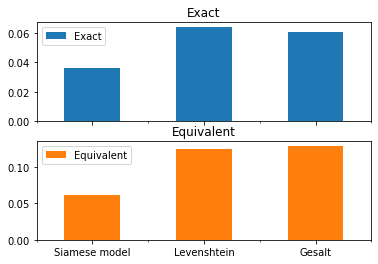

In [60]:
results.T.plot.bar(rot=0, subplots=True);

In [61]:
results.loc["Exact"].to_list()

[0.03583333333333332, 0.0638, 0.0605]

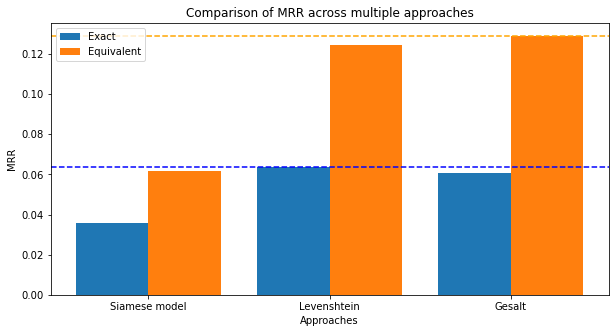

In [62]:
# print(results)
X = results.columns
Exact = results.loc["Exact"].to_list()
Equivalent = results.loc["Equivalent"].to_list()

X_axis = np.arange(len(X))
plt.figure(figsize=[10,5])

plt.bar(X_axis - 0.2, Exact, 0.4, label = 'Exact')
plt.bar(X_axis + 0.2, Equivalent, 0.4, label = 'Equivalent')

plt.axhline(y=max(Equivalent), color="orange", linestyle="--")
plt.axhline(y=max(Exact), color="blue", linestyle="--")
    
plt.xticks(X_axis, X)
plt.xlabel("Approaches")
plt.ylabel("MRR")
plt.title("Comparison of MRR across multiple approaches")
plt.legend()
plt.show()

# Translation tests

In [63]:
translation = '../data/translation_test_nps_202203171038.csv'
translation_set = preprocessInput(translation, MAXLEN)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5950 entries, 0 to 5949
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   np_name  5950 non-null   object
dtypes: object(1)
memory usage: 46.6+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['np_name'], dtype='object')
	New names: Index(['x'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
Dropping sequences longer than the maxlen of 65:
	Dropped 1 that exceeded the maximum sequence length.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping duplicate sequences:
	Dropped 35 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       5914 non-null   object
dtypes: o

In [64]:
translation_set.head()

,x
0,XTNNP
1,NWLMKV
2,WZMFCEA
3,AARONSROD
4,AARONS ROD WHOLE


In [65]:
encode_pad_tag(translation_set, 1, 0, MAXLEN)

Encoding and Padding: ----------------------------------
	Processing x
Tagging: -----------------------------------------------


,x,Processed_x,Match,Distance
0,XTNNP,"[24, 20, 14, 14, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,0
1,NWLMKV,"[14, 23, 12, 13, 11, 22, 0, 0, 0, 0, 0, 0, 0, ...",1,0
2,WZMFCEA,"[23, 26, 13, 6, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,0
3,AARONSROD,"[1, 1, 18, 15, 14, 19, 18, 15, 4, 0, 0, 0, 0, ...",1,0
4,AARONS ROD WHOLE,"[1, 1, 18, 15, 14, 19, 27, 18, 15, 4, 27, 23, ...",1,0
...,...,...,...,...
5909,ZINGIBER ZINGIBER WHOLE,"[26, 9, 14, 7, 9, 2, 5, 18, 27, 26, 9, 14, 7, ...",1,0
5910,ZYGAENA ERYTHRAEA WHOLE,"[26, 25, 7, 1, 5, 14, 1, 27, 5, 18, 25, 20, 8,...",1,0
5911,ZYGAENA INDICA WHOLE,"[26, 25, 7, 1, 5, 14, 1, 27, 9, 14, 4, 9, 3, 1...",1,0
5912,ZYGAENA LEWINI WHOLE,"[26, 25, 7, 1, 5, 14, 1, 27, 12, 5, 23, 9, 14,...",1,0


In [66]:
novelty = find_ranks(model, translation_set.sample(n=10), False)

Using column:  x
25/25 [==============================] - 0s 2ms/step


In [67]:
novelty.head(10)

,x,Processed_x,Match,Distance,rank1,rank2,rank3,rank4,rank5
5810,WITCHAZEL,"[23, 9, 20, 3, 8, 1, 26, 5, 12, 0, 0, 0, 0, 0,...",1,0,SPARTIUM JUNCEUM,ACTAEA RACEMOSA,TRITICUM AESTIVUM,PAUSINYSTALIA JOHIMBE,STERCULIA URENS
2184,ELEUTHERO WHOLE,"[5, 12, 5, 21, 20, 8, 5, 18, 15, 27, 23, 8, 15...",1,0,ELDERBERRY,COLEUS,HORSETAIL,CORDYCEPS,HORNY GOAT WEED
3147,JUGLANS REGIA L,"[10, 21, 7, 12, 1, 14, 19, 27, 18, 5, 7, 9, 1,...",1,0,LINARIA VULGARIS,JUGLANS NIGRA,FRANGULA ALNUS,GUGGUL,CLUSIA FLAVA
2552,FRANGULA SANGUINEA WHOLE,"[6, 18, 1, 14, 7, 21, 12, 1, 27, 19, 1, 14, 7,...",1,0,LICORICE,FRANGULA CAROLINIANA,FRANGULA ALNUS,GARCINIA,SENNA
1677,CITRUS VANGASY WHOLE,"[3, 9, 20, 18, 21, 19, 27, 22, 1, 14, 7, 1, 19...",1,0,CITRUS PARADISI,LICORICE,COPTIS,CITRUS AURANTIUM,GRAPEFRUIT
5311,TAO WHOLE,"[20, 1, 15, 27, 23, 8, 15, 12, 5, 0, 0, 0, 0, ...",1,0,COPTIS,CORDYCEPS,HORNY GOAT WEED,SENNA,COLEUS
924,BROADWHOLE PLANTAIN WHOLE,"[2, 18, 15, 1, 4, 23, 8, 15, 12, 5, 27, 16, 12...",1,0,BARBERRY,SENNA,IVY LEAF,HORNY GOAT WEED,BLACK COHOSH
2903,HESPERIS RUDERALIS WHOLE,"[8, 5, 19, 16, 5, 18, 9, 19, 27, 18, 21, 4, 5,...",1,0,COLEUS,HORNY GOAT WEED,COPTIS,CORDYCEPS,GOLDENSEAL
3931,OCIMUM SCUTELLARIOIDES WHOLE,"[15, 3, 9, 13, 21, 13, 27, 19, 3, 21, 20, 5, 1...",1,0,COPTIS,GOLDENSEAL,HORNY GOAT WEED,HORSETAIL,GUGGUL
3819,MUSCADINE WHOLE,"[13, 21, 19, 3, 1, 4, 9, 14, 5, 27, 23, 8, 15,...",1,0,LICORICE,COLEUS,MIRACLEFRUIT,GOLDENSEAL,GOJI BERRY


In [68]:
# test["Processed_np_name"] = test.np_name.apply(clean).apply(encode).apply(padding)

In [69]:
# test = preprocessInput(unmapped, converters = {"drug_name_original":str}, skip_blank_lines=True, na_filter=True, na_values="")
# test["Processed_drug_name_original"] = test[test.columns[0]].apply(clean).apply(encode).apply(padding)